In [1]:
import numpy as np
from typing import Dict, List
import matplotlib.pyplot as plt
from dataclasses import dataclass

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# we define a few types here.

@dataclass
class SegmentDefinition:
    """
        A definition of a data segment, e.g. "light users".

        Args:
            fraction_of_requests: the fraction of requests from the overall data this segment represents.
            ctr: the average CTR (positive labels) in this segment.
            ctr_logit_spread: how much variance we have around the ctr. So if the overall CTR is 0.05, not every sample will have 0.05 as its CTR.
            esr_logit_noise: how noisy are the esr predictions. We add noise to the logit of predictions, thus the actual prediction are still bounded in [0, 1].
            lsr_logit_noise: how noisy are the lsr predictions. 
    """
    fraction_of_requests: float
    ctr: float
    ctr_logit_spread: float
    esr_logit_noise: float
    lsr_logit_noise: float

# A segmerntation is a collection of segments, kyed by their name.
Segmentation = Dict[str, SegmentDefinition]


# A recall curve for a given segment (or overall), typically at position k will have recall@k
Recall = np.ndarray


@dataclass
class Session:
    """
        A class to represent a single session.

        Args:
            true_ctrs: the true CTRs of the items in the session
            esr_predictions: the ESR predictions of the items in the session
            lsr_predictions: the LSR predictions of the items in the session
    """
    true_ctrs: np.ndarray
    esr_predictions: np.ndarray
    lsr_predictions: np.ndarray

In [3]:
# we now define a few functions to generate data.

def logistic(x: np.ndarray) -> np.ndarray:
    """
        A logistic function.

        Args:
            x: the input to the logistic function

        Returns:
            the output of the logistic function
    """
    return 1 / (1 + np.exp(-x))

def logit(x: float) -> float:
    """
        The logit function.

        Args:
            x: the input to the logit function

        Returns:
            the output of the logit function
    """
    return np.log(x/(1-x))

def generate_single_session(segment: SegmentDefinition, number_of_candidates: int) -> Session:
    """
        Generate the data for a single session given the segment it belongs to.

        Args:
            segment: the segment definition
            number_of_candidates: the number of items in the input to ESR (the maximum number of items ESR can pass to LSR)

        Returns:
            a session

    """
    ctr_logit = logit(segment.ctr)
    ctr_logits = np.random.randn(number_of_candidates)*segment.ctr_logit_spread + ctr_logit
    esr_logits = ctr_logits + np.random.randn(number_of_candidates)*segment.esr_logit_noise
    lsr_logits = ctr_logits + np.random.randn(number_of_candidates)*segment.lsr_logit_noise
    true_ctrs = logistic(ctr_logits)
    esr_predictions = logistic(esr_logits)
    lsr_predictions = logistic(lsr_logits)

    return Session(true_ctrs=true_ctrs, esr_predictions=esr_predictions, lsr_predictions=lsr_predictions)


def generate_data(segmentation: Segmentation, number_of_simulated_sessions: int, number_of_candidates: int) -> Dict[str, List[Session]]:
    """
        Generate the data for a given segmentation.

        Args:
            segmentation: the segmentation definition
            number_of_simulated_sessions: the number of simulated sessions to create per segment
            number_of_candidates: the number of items in the input to ESR (the maximum number of items ESR can pass to LSR)

        Returns:
            a dictionary mapping segment names to lists of sessions for each segment

    """
    return {
        segment_name: [
            generate_single_session(segment, number_of_candidates) for i in range(number_of_simulated_sessions)
        ]
        for segment_name, segment in segmentation.items()
    }


In [4]:
# we now generate some data, using some very basic, examplary segmentation.
# heavy users dominate the data in our simulated example, and have better predictions both in ESR and LSR than light users.

light_users = SegmentDefinition(
    fraction_of_requests=0.3,
    ctr=0.05,
    ctr_logit_spread=1,
    esr_logit_noise=1,
    lsr_logit_noise=0.5,
)

heavy_users = SegmentDefinition(
    fraction_of_requests=0.7,
    ctr=0.1,
    ctr_logit_spread=1,
    esr_logit_noise=0.5,
    lsr_logit_noise=0.25,
)

segmentation = {
    "light_users": light_users,
    "heavy_users": heavy_users,
}

data = generate_data(segmentation, 1000, 200)

In [5]:
def _calculate_single_session_soft_recall(session: Session, user_visible_items: int) -> np.ndarray:
    """
        Calculate the soft recall for a single session.

        Args:
            session: the session
            user_visible_items: the number of items the user can see (this caps the actual value we get from ranking - we just need to get the top user_visible_items items correctly)

        Returns:
            the soft recall for the session
    """

    def calculate_user_value(predictions: np.ndarray, user_visible_items: int) -> float:
        # calculate the value of the top user_visible_items items
        return np.sum(np.sort(predictions)[::-1][:user_visible_items])

    # estimate how much value we can ideally get by ranking according to LSR, and calculating the value of the top
    # user_visible_items items 
    potential_value = calculate_user_value(session.lsr_predictions, user_visible_items)

    # then calculate the soft recall @ n, for all n's, by sorting LSR predictions according to ESR, and calculating the value of the top
    # user_visible_items items
    lsr_sorted_by_esr = np.array([lsr for esr, lsr in sorted(zip(session.esr_predictions, session.lsr_predictions), reverse=True)])
    recall = np.array([calculate_user_value(lsr_sorted_by_esr[:n], user_visible_items)/potential_value for n in range(len(lsr_sorted_by_esr)+1)])
    return recall

def _calculate_segment_soft_recall(sessions: List[Session], user_visible_items: int) -> Recall:
    """
        Calculate the average soft recall for a list of sessions coming from a segment.

        Args:
            sessions: the sessions for the segment
            user_visible_items: the number of items the user can see 

        Returns:
            the average soft recall for the segment
    """
    recalls = np.array([_calculate_single_session_soft_recall(session, user_visible_items) for session in sessions])
    recall = recalls.sum(axis=0)/len(sessions)
    return recall


def calculate_segmentation_soft_recall(data: Dict[str, List[Session]], user_visible_items: int) -> Dict[str, Recall]:
    """
        Calculate the average soft recall for a segmentation.

        Args:
            data: a dictionary mapping segment names to lists of simulated sessions for each segment
            user_visible_items: the number of items the user can see

        Returns:
            a dictionary mapping segment names to Recall objects
    """
    return {
        segment_name: _calculate_segment_soft_recall(sessions, user_visible_items)
        for segment_name, sessions in data.items()
    }

In [6]:
soft_recall = calculate_segmentation_soft_recall(data, 10)

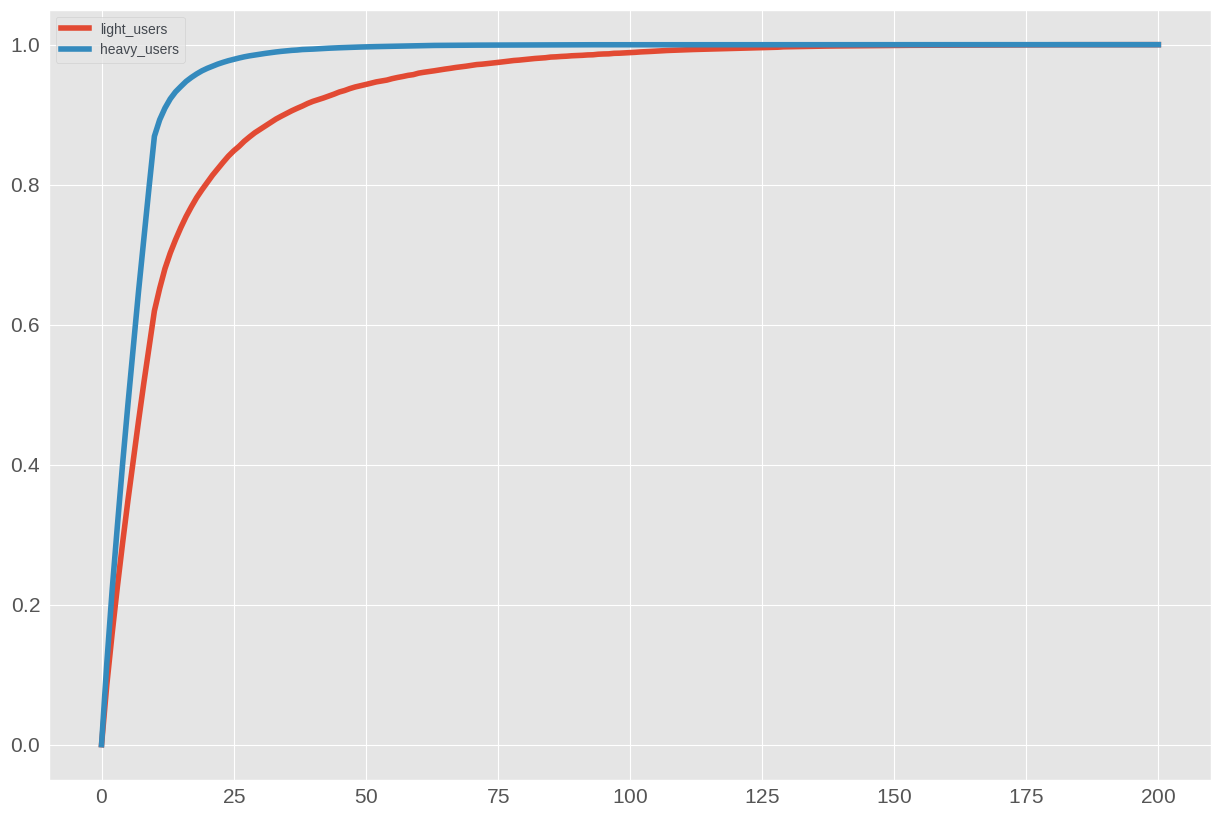

In [7]:
# we can observe that ESR's recall beahves differently between light and heavy users,
# Because the user is only able to see 10 items, the recall saturates quickly, faster for heavy users.
for segment_name, recall in soft_recall.items():
    plt.plot(recall, label=segment_name)
plt.legend()

In [8]:
# Let's now define a few types to represent policies

Policy = Dict[str, int] # a policy is a dictionary mapping segment names to the number of items to pass from ESR to LSR for that segment
PolicyList = List[Policy] # a list of policies, typically one policy per allowable budget


In [9]:
# Now we define functions to generate policies and how to calculate their cost and value (as measured by average recall)


def generate_uniform_policy(
    segmentation: Segmentation,
    number_of_candidates: int
) -> PolicyList:
    """
        Generate a policy list where each policy is uniform across all segments.
        That is, we send the same number of items from ESR to LSR for each segment in each policy, and increase the number of items throughout the policy list.

        Args:
            segmentation: the segmentation
            number_of_candidates: the maximum number of items we can pass from ESR to LSR for each segment

        Returns:
            a list of policies, where each policy is uniform across all segments

    """
    return [
        {segment_name: i for segment_name in segmentation}
        for i in range(1, number_of_candidates+1)
    ]



def generate_personalized_policy(
    recalls: Dict[str, Recall]
) -> PolicyList:
    """
        creates an incremental list of personalized policies for the given segments

        Args:
            recalls: a list dictionary Recall objects, one for each segment
        
        Returns:
            A list of policies. At index i this list contains a dictionary representing the policy given a budget of i% of the total samples.
            The dictionary maps the name of the segment to the number of items to pass from ESR to LSR for that segment.

    """


    def compute_segment_weighted_marginal_recall(recall: Recall) -> np.ndarray:
        assert recall[0] == 0
        return recall[1:] - recall[:-1]  # note that recall[0] is 0


    marginal_recall = {
        segment_name: compute_segment_weighted_marginal_recall(recall)
        for segment_name, recall in recalls.items()
    }

    personalized_policy = {segment_name: 0 for segment_name in recalls}
    personalized_policy_list = []

    # The next_position_values array holds the value of the current position to consider for each segment.
    # For example if there are 2 segments and we have selected 100 items from segment 1 and 50 from segment 2
    # this array will hold the values of position 101 for segment 1 and position 51 for segment 2.
    # It is updated in every iteration
    next_position_values = {
        segment_name: marginal_recall[segment_name][0] for segment_name in recalls
    }

    while any(x>=0 for x in next_position_values.values()):
        # increase the session size for the segment with the highest value
        max_segment = max(next_position_values, key=next_position_values.get)
        personalized_policy[max_segment] += 1

        # if we haven't already included all the positions for this segment
        # update the next_position_values array for this segment to the value of the next position
        if personalized_policy[max_segment] < len(marginal_recall[max_segment]):
            next_position_values[max_segment] = marginal_recall[max_segment][
                personalized_policy[max_segment]
            ]
        else:  # if we have already included all the positions then disregard this segment in the future
            next_position_values[max_segment] = -1


        personalized_policy_list.append(personalized_policy.copy())

    return personalized_policy_list

def calculate_recall_for_policy_list(
    recalls: Dict[str, Recall],
    policy_list: PolicyList,
    segmentation: Segmentation,
) -> List[float]:
    """
        Calculate the overall recall for each policy in a given policy list

        Args:
            recalls: a list dictionary Recall objects, one for each segment
            policy_list: A list of policies
            segmentation: The definition of how the data is segmented

        Returns:
            A list containing the overall recall for each policy in the input policy_list         
    """
    def calculate_recall_for_policy(recalls: Dict[str, Recall], policy: Policy, segmentation: Segmentation) -> float:
        recall = np.sum(
            [
                recalls[segment_name][esr_items] * segmentation[segment_name].fraction_of_requests
                for segment_name, esr_items in policy.items()
            ]
        )
        return recall
        
    return [calculate_recall_for_policy(recalls, policy, segmentation) for policy in policy_list]


def calculate_cost_for_policy_list(
    policy_list: PolicyList,
    segmentation: Segmentation,
) -> List[float]:
    """
        calculates the cost of each policy (i.e. the number of items LSR needs to process) for each policy given in the input policy list

        Args:
            policy_list: A list of policies
            segmentation: The definition of how the data is segmented

        Returns:
            A list containing the overall cost for each policy in the input policy_list         
    """
    def calculate_cost_for_policy(policy: Policy, segmentation: Segmentation) -> float:
        costs = np.sum(
            [
                esr_items * segmentation[segment_name].fraction_of_requests
                for segment_name, esr_items in policy.items()
            ]
        )
        return costs
        
    return [calculate_cost_for_policy(policy, segmentation) for policy in policy_list]


In [ ]:
# generate the personalize policy list, and for each policy calculate its recall and cost

In [10]:
personalized_policy_list = generate_personalized_policy(soft_recall)

In [11]:
personalized_policy_recall = calculate_recall_for_policy_list(soft_recall, personalized_policy_list, segmentation)
personalized_policy_cost = calculate_cost_for_policy_list(personalized_policy_list, segmentation)

In [14]:
# generate the uniform policy list, and for each policy calculate its recall and cost

In [12]:
uniform_policy_list = generate_uniform_policy(segmentation, 200)

In [13]:
uniform_policy_recall = calculate_recall_for_policy_list(soft_recall, uniform_policy_list, segmentation)
uniform_policy_cost = calculate_cost_for_policy_list(uniform_policy_list, segmentation)

In [15]:
# compare between uniform and personalized policies. For a given budget, the personalized policy is better than the uniform policy

Text(0, 0.5, 'average recall per request (overall recall)')

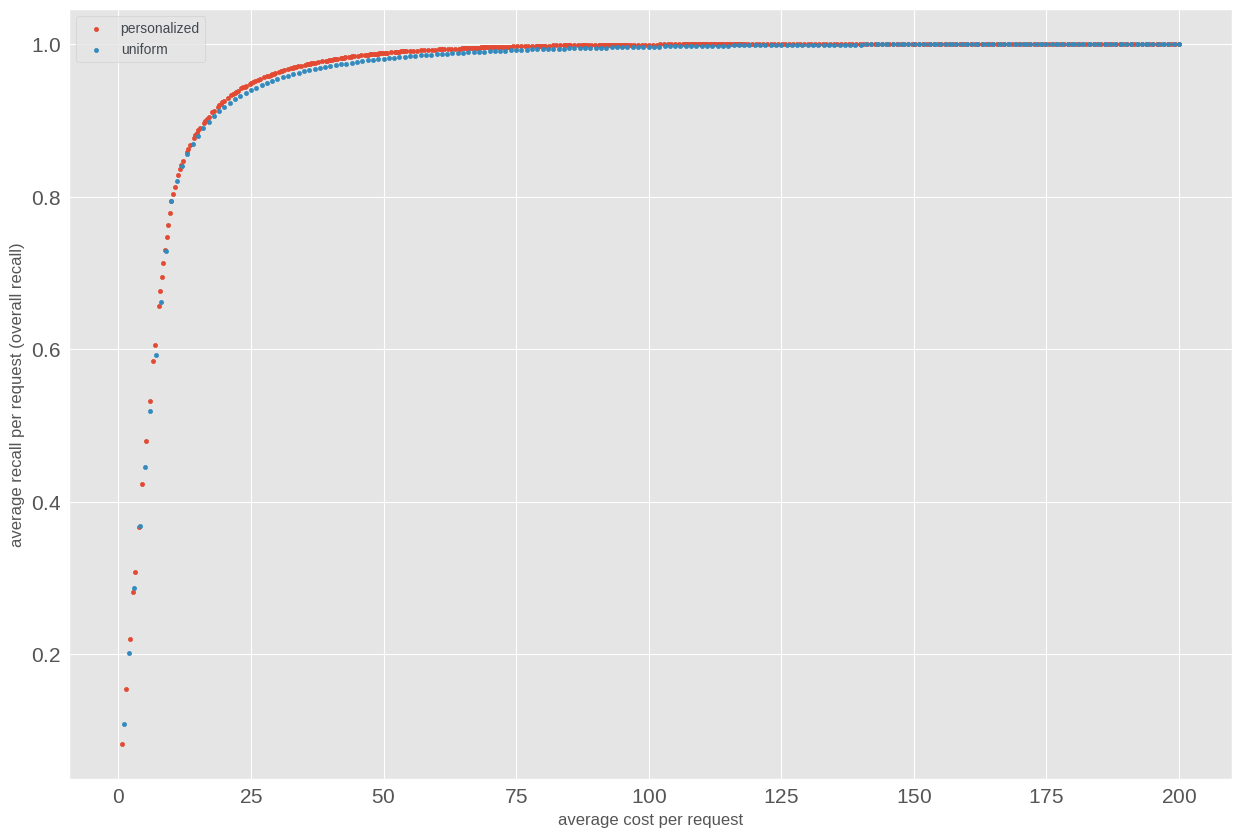

In [16]:
plt.scatter(x=personalized_policy_cost, y=personalized_policy_recall, label="personalized", marker='.')
plt.scatter(x=uniform_policy_cost, y=uniform_policy_recall, label="uniform", marker='.')
plt.legend()
plt.xlabel('average cost per request')
plt.ylabel('average recall per request (overall recall)')